$$
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\Cov}{\mathrm{Cov}}
\newcommand{\SampleAvg}{\frac{1}{N({S})} \sum_{s \in {S}}}
\newcommand{\indic}{\mathbb{1}}
\newcommand{\avg}{\overline}
\newcommand{\est}{\hat}
\newcommand{\trueval}[1]{#1^{*}}
\newcommand{\Gam}[1]{\mathrm{Gamma}#1}
$$

$$
\renewcommand{\like}{\cal L}
\renewcommand{\loglike}{\ell}
\renewcommand{\err}{\cal E}
\renewcommand{\dat}{\cal D}
\renewcommand{\hyp}{\cal H}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{\mathbf x}
\renewcommand{\v}[1]{\mathbf #1}
$$

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import stats
from scipy.stats import norm, gamma
from scipy.stats import distributions
import seaborn as sns
import time
sns.set_style('whitegrid')
sns.set_context('poster')
plt.rcParams['figure.figsize'] = (20,10)


# Introduction

MCMC stands for Monte Carlo Markov Chain, where Monte Carlo refers to random number generation and Markov Chain refer to a sequence of random variables that each depend only on its immediate previous random variable. 

MCMC is a special family of sampling algorithms. Sampling algorithm allows us to draw sample from a given probability distribution. By drawing samples and applying the law of large number we can compute the expectation, integrals, or optimize some function!

MCMC sample methods are central to Bayesian statistics since the denominator in the Bayes rule normally involves computing integral with respect to many parameters. $$p(\theta \mid \cal{D}) = \frac{p(\cal{D} \mid \theta) p(\theta)}{p(D)}$$

where $p(D) = \int p(\cal{D} \mid \theta) p(\theta) d\theta$. This is an expensive operation. MCMC methods allows us to approximate the integral. This is why MCMC is central to the rising popularity of Bayesian statistics in the last decade. 

Before we discuss MCMC, it is instructive to learn a basic but fundamental sampling methods.




## Basic Sampling Methods

### Inverse Transform (aka probability integral transform)

We have the following Lemma sometimes called the *probability integral transform*

>If $U \sim \mathcal{U}_{[0,1]}$, then the random variable $F^{-1}(U)$ has the distribution $F$, where $F^{-1}(u) = inf \{x: F(x)>= u \}$, i.e., the generalized inverse function of $F$.

A proof can be found at Statistical Inference, Casella.

Given an invertible CDF F of a distribution of x, we can perform sampling using the following algorithm.
1. get a uniform sample u from uniform(0,1)
2. sovle for x: $x = F^{-1}(u)$
3. repeat.

For example, we want to draw samples from the exponential distribution $f(x) = \lambda e^{-\lambda x}$ for $x>0$. Solving $x = F^{-1}(u)$, we have $x = (-1/\lambda)\ln(1-u)$

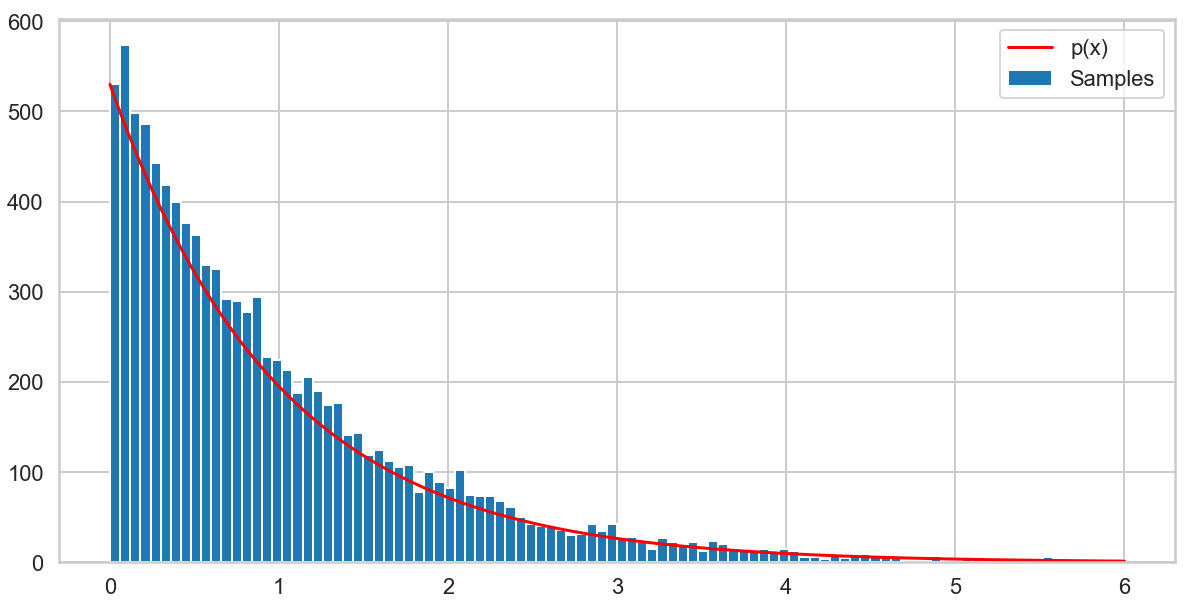

In [43]:
# drawing from exponential distribution f(x,1), lambda=1
# https://en.wikipedia.org/wiki/Exponential_distribution
p = lambda x: np.exp(-x)
CDF = lambda x: 1 - np.exp(-x)
invCDF = lambda r: -np.log(1-r)
xmin = 0
xmax = 6
rmin = CDF(xmin)
rmax = CDF(xmax)
N = 10000
# generate samples in [rmin rmax] the invert the CDF 
# to get the samples of our target distribution
R = np.random.uniform(rmin,rmax, N)
X = invCDF(R)
hinfo = np.histogram(X,100)
plt.hist(X, bins=100, label='Samples')

# plot our (normalized) function
x = np.linspace(xmin,xmax,1000)
plt.plot(x, hinfo[0][0]*p(x), color='r', label=u'p(x)')
plt.legend()


### Box-Muller Algorithm (Normal distribution N(0,1))

The algorithm is as followed:

1. Generate $U_1, U_2$ iid $\mathcal{U}_{[0,1]}$
2. Define $x_1 = \sqrt{-2\log(u_1)} cos(2\pi u_2)$ and $x_2 = \sqrt{-2\log(u_1)} sin(2\pi u_2)$
3. Take $x_1$ and $x_2$ as two independent draws from $\mathcal{N}(0,1)$

A proof can be found here https://math.stackexchange.com/questions/1110168/proof-of-the-box-muller-method

### Rejection Sampling
This is quite simple. The key idea is to generate samples from a uniform distribution with a support as a rectangle [xmin, xmax] * [0, ymax], see how many fall below y(x) at a specific x.

The algorithm is as follows.
1. Draw x uniformly from [xmin, xmax]
2. Draw y uniformly from [0, ymax]
3. if y < f(x), accept the sample x
4. otherwise reject it
5. repeat

The following code generate samples from distribution $f(x) = e^{-x}$ for $x \in[0,10]$

Count 99851 Accepted 10000


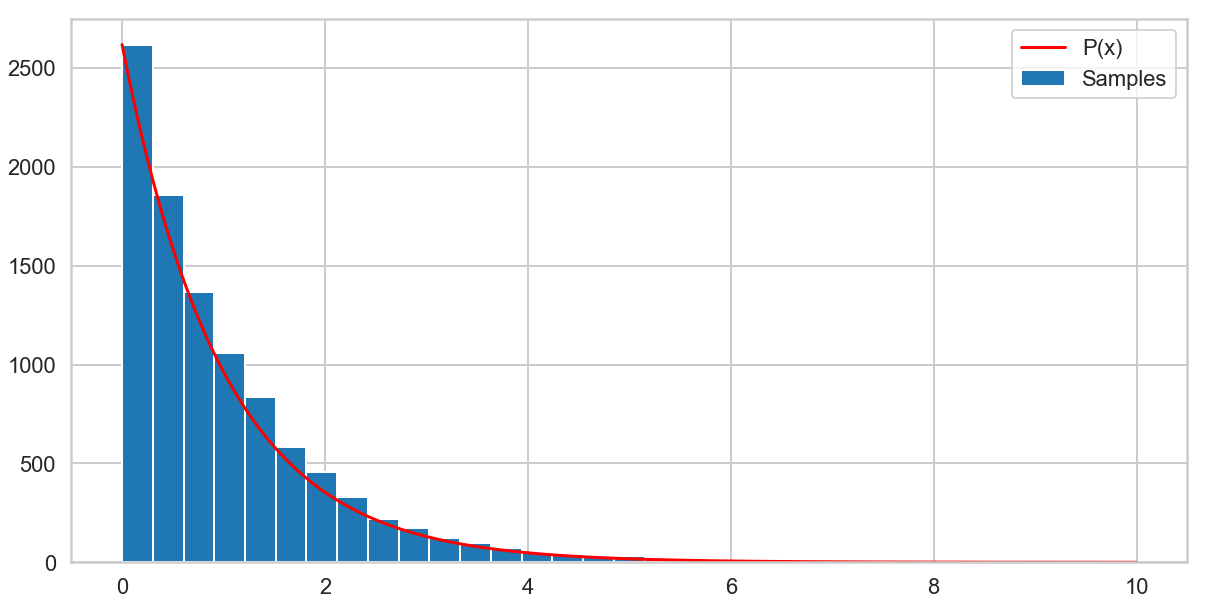

In [44]:
P = lambda x: np.exp(-x)

# domain limits
xmin = 0 # the lower limit of our domain
xmax = 10 # the upper limit of our domain

# range limit (supremum) for y
ymax = 1
#you might have to do an optimization to find this.

N = 10000 # the total of samples we wish to generate
accepted = 0 # the number of accepted samples
samples = np.zeros(N)
count = 0 # the total count of proposals

# generation loop
while (accepted < N):
    
    # pick a uniform number on [xmin, xmax) (e.g. 0...10)
    x = np.random.uniform(xmin, xmax)
    
    # pick a uniform number on [0, ymax)
    y = np.random.uniform(0,ymax)
    
    # Do the accept/reject comparison
    if y < P(x):
        samples[accepted] = x
        accepted += 1
    
    count +=1
    
print("Count",count, "Accepted", accepted)

# get the histogram info
hinfo = np.histogram(samples,30)

# plot the histogram
plt.hist(samples,bins=30, label=u'Samples');

# plot our (normalized) function
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, hinfo[0][0]*P(xvals), 'r', label=u'P(x)')

# turn on the legend
plt.legend()


Notice that in the previous example, we need about 100K proposals to accept 10K samples. This is a waste of computation. This is because in the range $[4,10]$, we have a very low probabilty density. This problem is called **low acceptance probability**.

To remedy the low acceptance probability , we can introduct a **proposal density g(x)**. which should have the following properties: 
- easy to sample from
- M is beween 1, and $\infty$ so that Mg(x) > f(x) on the entire domain of interest
- ideally g(x) will be somewhat close to f so that you will sample more in the high density regions and less in the low density regions. 

There are two equivalent view of this strategy: Algorithm 1 and Algorithm 2. Algorithm 1 is more direct, easy to understand.

Algorithm 1:
Note that in the picture $g(x)$ is $Q(x)$ and f(x) is $P^*(x)$.

![rejection sampling](../gfx/rejection_sampling.png)



Algorithm 2:
- Draw x from your proposal distribution g(x)
- Draw y uniformly from [0,1] 
- if y< f(x)/Mg(x)accept the sample otherwise reject it repeat


Notice that the two algorithm are equivalent. In Algorithm 2, step 3, $y < f(x)/Mg(x)$ is equivalent to $yMg(x) < f(x)$, since y is choosen uniformly from $[0,1]$. This is equivalent to sampling from $[0, Mg(x)]$ (or $[0, CQ(x)]$ as in the picture) which is like in the Algorithm 1.

Count 23910 Accepted 10000


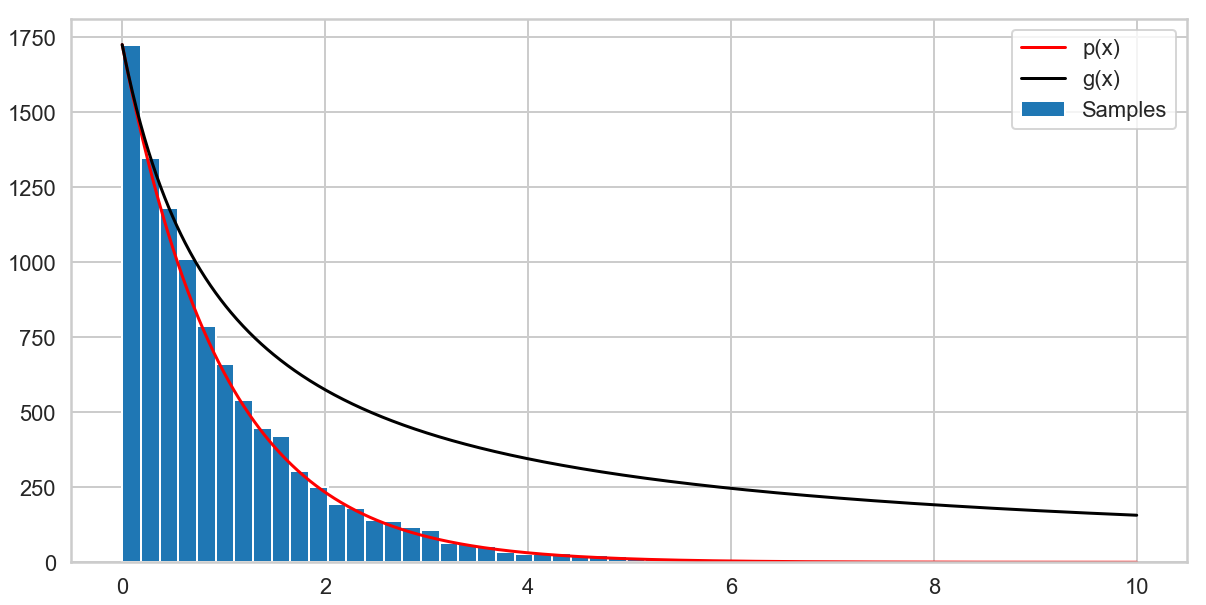

In [45]:
p = lambda x: np.exp(-x)  # our distribution
g = lambda x: 1/(x+1)  # our proposal pdf (we're thus choosing M to be 1)
invCDFg = lambda x: np.log(x +1) # generates our proposal using inverse sampling

# domain limits
xmin = 0 # the lower limit of our domain
xmax = 10 # the upper limit of our domain

# range limits for inverse sampling
umin = invCDFg(xmin)
umax = invCDFg(xmax)

N = 10000 # the total of samples we wish to generate
accepted = 0 # the number of accepted samples
samples = np.zeros(N)
count = 0 # the total count of proposals

# generation loop
while (accepted < N):
    
    # Sample from g using inverse sampling
    u = np.random.uniform(umin, umax)
    xproposal = np.exp(u) - 1
    
    # pick a uniform number on [0, 1)
    y = np.random.uniform(0,1)
    
    # Do the accept/reject comparison
    if y < p(xproposal)/g(xproposal):
        samples[accepted] = xproposal
        accepted += 1
    
    count +=1
    
print("Count", count, "Accepted", accepted)

# get the histogram info
hinfo = np.histogram(samples,50)

# plot the histogram
plt.hist(samples,bins=50, label=u'Samples');

# plot our (normalized) function
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, hinfo[0][0]*p(xvals), 'r', label=u'p(x)')
plt.plot(xvals, hinfo[0][0]*g(xvals), 'k', label=u'g(x)')

# turn on the legend
plt.legend()

One clear effect is that we need 24109 proposal to get 10K samples.

### Importance Sampling

This is a directly a method to compute integrals, which we need to perform Bayes analysis.

For example suppose we have $X \sim f(x)$, and we want to compute $E(h(x))$ wrt to this density, we have 


$$\begin{align}
    E_f[h] &= \int_{V}f(x)h(x)dx\\
            &= \int h(x)g(x)\frac{f(x)}{g(x)}dx\\
            &= E_g[h(x)\frac{f(x)}{g(x)}]
\end{align}$$

Here $g(x)$ is a function that is easy to sample from and is close to the function $f(x)$. Now we can approximate the last expression by Monte Carlo methods 

$$E_f[h] = \lim_{N \rightarrow \infty}\frac{1}{N}\sum_{x_i \sim g(.)}h(x_i)\frac{f(x_i)}{g(x_i)}$$

The fundamental difference compared to rejection sampling is we use all the samples. But the contribution to the expection is weighted by $w(x_i) = \frac{f(x_i)}{g(x_i)}$

Example: Calculate $\int_{0}^{\pi}sin(x)xdx$

The function has a shape that is similar to Gaussian and therefore we choose here a Gaussian as importance sampling distribution.

In [46]:
from scipy import stats
from scipy.stats import norm

mu = 2;
sig =.7;

f = lambda x: np.sin(x)*x
infun = lambda x: np.sin(x)-x*np.cos(x)
p = lambda x: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(x-mu)**2/(2.0*sig**2))
normfun = lambda x:  norm.cdf(x-mu, scale=sig)


Exact solution is:  3.141592653589793


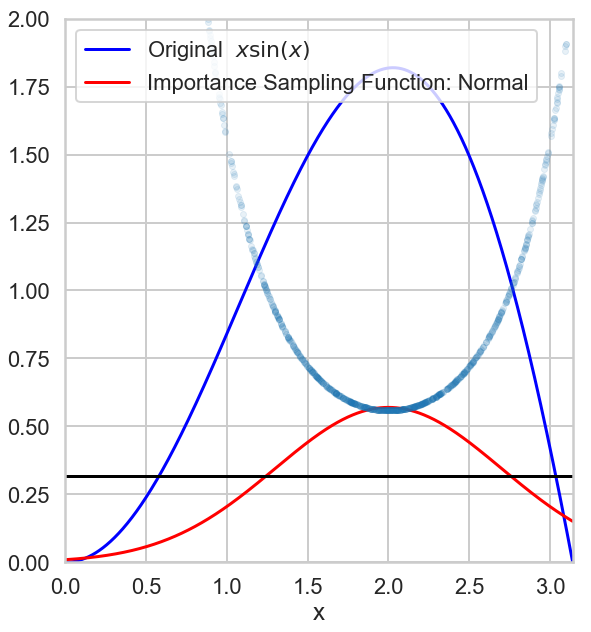

In [47]:
# range of integration
xmax =np.pi 
xmin =0

# Number of draws 
N =1000

# Just want to plot the function
x=np.linspace(xmin, xmax, 1000)
plt.subplot(1,2,1)
plt.plot(x, f(x), 'b', label=u'Original  $x\sin(x)$')
plt.plot( x, p(x), 'r', label=u'Importance Sampling Function: Normal')
plt.plot(x, np.ones(1000)/np.pi,'k')

# drawing from normal distribution
xis = mu + sig*np.random.randn(N,1);
plt.plot(xis, 1/(np.pi*p(xis)),'.', alpha=0.1)

# some plotting miscell
plt.xlim([0, np.pi])
plt.ylim([0,2])
plt.xlabel('x')
plt.legend()
# =============================================
# EXACT SOLUTION 
# =============================================
Iexact = infun(xmax)-infun(xmin)
print("Exact solution is: ", Iexact)

Mean basic MC estimate:  3.1373963594575915
Standard deviation of our estimates:  0.060691303100339995
Mean importance sampling MC estimate:  3.1421826010357736
Standard deviation of our estimates:  0.015157243334462124


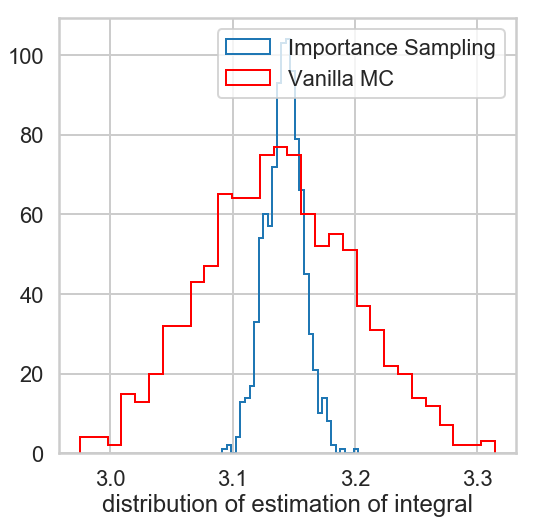

In [48]:
plt.figure(figsize=(18,8))
# ============================================
# VANILLA MONTE CARLO 
# ============================================
Ivmc = np.zeros(1000)
for k in np.arange(0,1000):
    x = np.random.uniform(low=xmin, high=xmax, size=N)
    Ivmc[k] = (xmax-xmin)*np.mean( f(x))

print("Mean basic MC estimate: ", np.mean(Ivmc))
print("Standard deviation of our estimates: ", np.std(Ivmc))

# ============================================
# IMPORTANCE SAMPLING 
# ============================================
# CHOOSE Gaussian so it similar to the original functions

Iis = np.zeros(1000)
for k in np.arange(0,1000):
    # DRAW FROM THE GAUSSIAN mean =2 std = sqrt(0.7) 
    xis = mu + sig*np.random.randn(N,1);
    #hist(x)
    xis = xis[ (xis<xmax) & (xis>xmin)] ;

    # normalization for gaussian from 0..pi
    normal = normfun(np.pi)-normfun(0);


    Iis[k] =np.mean(f(xis)/p(xis))*normal;

print("Mean importance sampling MC estimate: ", np.mean(Iis))
print("Standard deviation of our estimates: ", np.std(Iis))
plt.subplot(1,2,2)
plt.hist(Iis,30, histtype='step', label=u'Importance Sampling');
plt.hist(Ivmc, 30, color='r',histtype='step', label=u'Vanilla MC');
plt.gca().set_xlabel('distribution of estimation of integral')
plt.legend()

### Beta Importance Sampling
Let's implement importance sampling for a Beta distribution. Note that this is just for demonstration. To draw from a Beta distribution we have much better algorithm.

In [49]:
from scipy.stats import beta
from scipy.stats import norm
from scipy.stats import uniform

Perform sampling

In [50]:
N = 1000000
b_dist = beta(a=2,b=11)

# sampling directly using scipy
beta_samples = b_dist.rvs(N)

# importance sampling, proposal distribution uniform
u_samples = uniform.rvs(size=N)
# u_samples.sort()
eval_pdf = b_dist.pdf(u_samples)
weights = 1/N
w = eval_pdf / weights
w = w / np.sum(w)
# resamples them according to this weight
importance_beta_samples = np.random.choice(u_samples, p=w, replace=True, size=N)


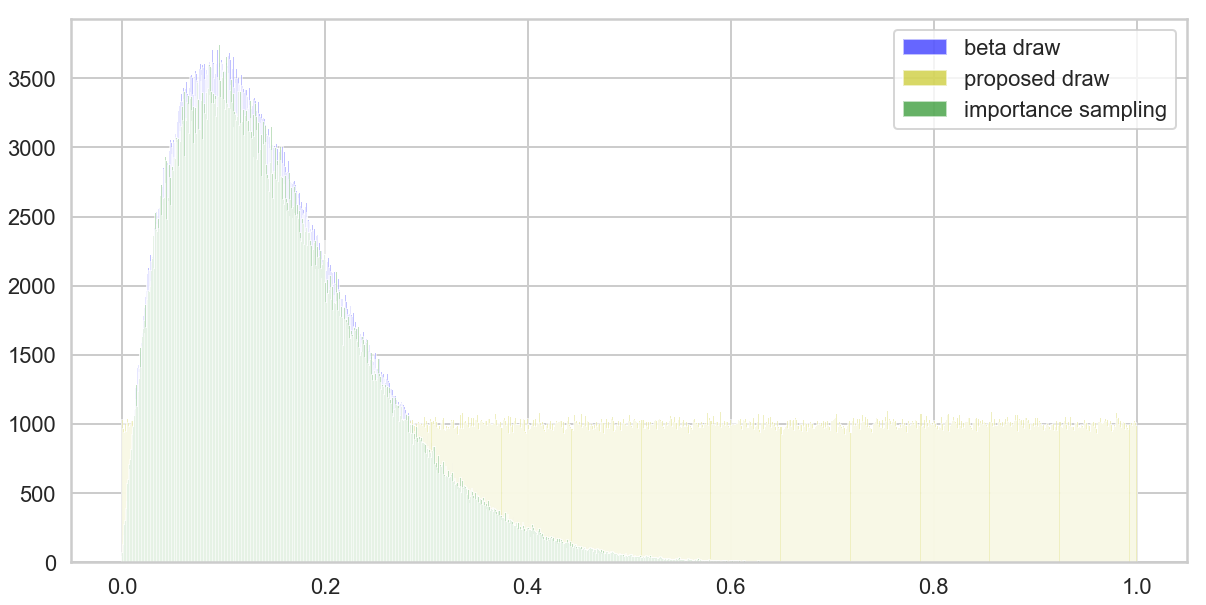

In [51]:
# plotting
plt.hist(beta_samples, bins=1000, alpha=0.6, color='b', label='beta draw');
plt.hist(u_samples, bins=1000, alpha=0.6, color='y', label='proposed draw');
plt.hist(importance_beta_samples, bins=1000, alpha=0.6, color='g', label='importance sampling');
plt.legend();

We in fact have an empirical distribution of Beta(a=2,b=11)

In [52]:
# Estimation of probability densities by empirical density functionst by M. S. WATERMAN and D. E. WHITEMAN
def empirical_cdf(x, samples):
    return np.sum(x > samples) / samples.shape[0]
    
def empirical_pdf(x, samples, epsilon=0.001):
    return (empirical_cdf(x + epsilon,samples) - empirical_cdf(x-epsilon, samples)) / (2 * epsilon)

In [53]:
print('empirical density of Beta(2,11) at 0.3: ', empirical_pdf(0.3, importance_beta_samples))
print('true density Beta(2,11) at 0.3: ', b_dist.pdf(0.3))

empirical density of Beta(2,11) at 0.3:  1.1164999999999647
true density Beta(2,11) at 0.3:  1.11860198604


# Monte Carlo Integration Computation

Suppose we want to compute $I = \int_{a}^{b}f(x)dx$. We can use Monte Carlo integration method. The idea is to relate $I$ to the expectation of  $f(x)$ wrt to the uniform distribution over $[a,b]$, $U_{ab}(x)$. Specifically, we have:

$$J = \int_a^b f(x)U_{ab}(x)dx = E_{U}f(x)$$

And we have $$I = (b-a) * J$$

Recall that using law of large numbers we can compute $J$, by repeatedly sample $X \sim U_{ab}(X)$, and compute $f(X)$ and the sample mean.

Hence

$$I = V\lim_{n \rightarrow \infty} \frac{1}{N}\sum_{x_i \sim U} f(x_i),$$ where V here is $b-a$

We now use sampling to compute

$$I =  \int_{2}^{3}[x^2 + 4xsin(x)]dx$$

In [54]:
def f(x):
    return x**2 + 4*x*np.sin(x)

# closed from of integration
def intf(x):
    return x**3/3.0+4.0*np.sin(x) - 4.0*x*np.cos(x)   

In [55]:
# limits of integration
a = 2
b = 3

# size of simulation
N = 10000

# select randomly x
X = np.random.uniform(low=a, high=b, size=N)

# compute f(x)
Y = f(X)

# compute integration
V = b-a
print('approximated integration: ', V * np.mean(Y))
print('exact integration: ', intf(b) - intf(a))

approximated integration:  11.809938020538462
exact integration:  11.811358925098283
